In [121]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pickle


import sys, os
sys.path.append(os.path.abspath('..'))
from research.pkg.lib import *


# import mplfinance as mpf
%matplotlib inline

plt.rcParams['lines.linewidth'] = 0.5 

mpl.rcParams.update({'font.size': 3, 'lines.linewidth': 0.5, 'figure.dpi': 300})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from minizinc import Instance, Model, Solver, Status as mzStatus
import nest_asyncio
nest_asyncio.apply()

In [4]:

# Machine learning libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [29]:
def call_mzn_model(model_name,model_params):
    with open(f'pars-{model_name}.dzn.json', 'w+') as f: f.write(json.dumps(model_params, indent=2))

    # print('Model params:', model_params)

    mzn_model = Model(f'{model_name}.mzn')
    gecode = Solver.lookup("gecode")
    instance = Instance(gecode, mzn_model)

    for k,v in model_params.items(): instance[k] = v
    result = instance.solve()

    return result


In [117]:

def plot_candles(wdf, ax=None, kwargs={}):
    if ax is None:
        fig, ax = plt.subplots(**kwargs)

    up, down = wdf[wdf.close >= wdf.open], wdf[wdf.close < wdf.open]
    col1,col2 = 'green','red'
    width, width2 = .1, .02
    # Plotting up prices of the stock
    ax.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
    ax.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
    ax.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)
    # Plotting down prices of the stock
    ax.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
    ax.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
    ax.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)    
    plt.xticks(rotation=30, ha='right')
    return ax

In [146]:
pair = 'BTC_USDT'
timeframe = '4h'

exchange = 'binance'
odf = pd.read_json(f'../freq-user-data/data/{exchange}/{pair}-{timeframe}.json'
# exchange = 'kucoin'
# odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'
).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=False)
).set_index('dtime').sort_index()

print(odf.shape)
odf.head(4)

(12676, 6)


,timestamp,open,high,low,close,volume
dtime,,,,,,
2017-08-17 04:00:00,1502942400000,4261.48,4349.99,4261.32,4349.99,82.088865
2017-08-17 08:00:00,1502956800000,4333.32,4485.39,4333.32,4427.30,63.619882
2017-08-17 12:00:00,1502971200000,4436.06,4485.39,4333.42,4352.34,174.562001
2017-08-17 16:00:00,1502985600000,4352.33,4354.84,4200.74,4325.23,225.109716


In [171]:
odf['bo_low'] = odf[['open', 'close']].min(axis=1)
odf['bo_high'] = odf[['open', 'close']].max(axis=1)
odf['bo_range'] = odf.bo_high.divide(odf.bo_low).apply(np.log)
odf['ca_range'] = odf.high.divide(odf.low).apply(np.log)
odf

,timestamp,open,high,low,close,volume,bo_low,bo_high,bo_range,ca_range
dtime,,,,,,,,,,
2017-08-17 04:00:00,1502942400000,4261.48,4349.99,4261.32,4349.99,82.088865,4261.48,4349.99,0.020557,0.020595
2017-08-17 08:00:00,1502956800000,4333.32,4485.39,4333.32,4427.30,63.619882,4333.32,4427.30,0.021456,0.034491
2017-08-17 12:00:00,1502971200000,4436.06,4485.39,4333.42,4352.34,174.562001,4352.34,4436.06,0.019053,0.034468
2017-08-17 16:00:00,1502985600000,4352.33,4354.84,4200.74,4325.23,225.109716,4325.23,4352.33,0.006246,0.036027
2017-08-17 20:00:00,1503000000000,4307.56,4369.69,4258.56,4285.08,249.769913,4285.08,4307.56,0.005232,0.025761
...,...,...,...,...,...,...,...,...,...,...
2023-06-01 16:00:00,1685635200000,26894.47,27175.00,26656.00,26862.68,8974.247130,26862.68,26894.47,0.001183,0.019283
2023-06-01 20:00:00,1685649600000,26862.68,26942.98,26713.34,26817.93,3659.356110,26817.93,26862.68,0.001667,0.008560
2023-06-02 00:00:00,1685664000000,26817.93,27017.00,26505.00,27000.00,7016.041600,26817.93,27000.00,0.006766,0.019133


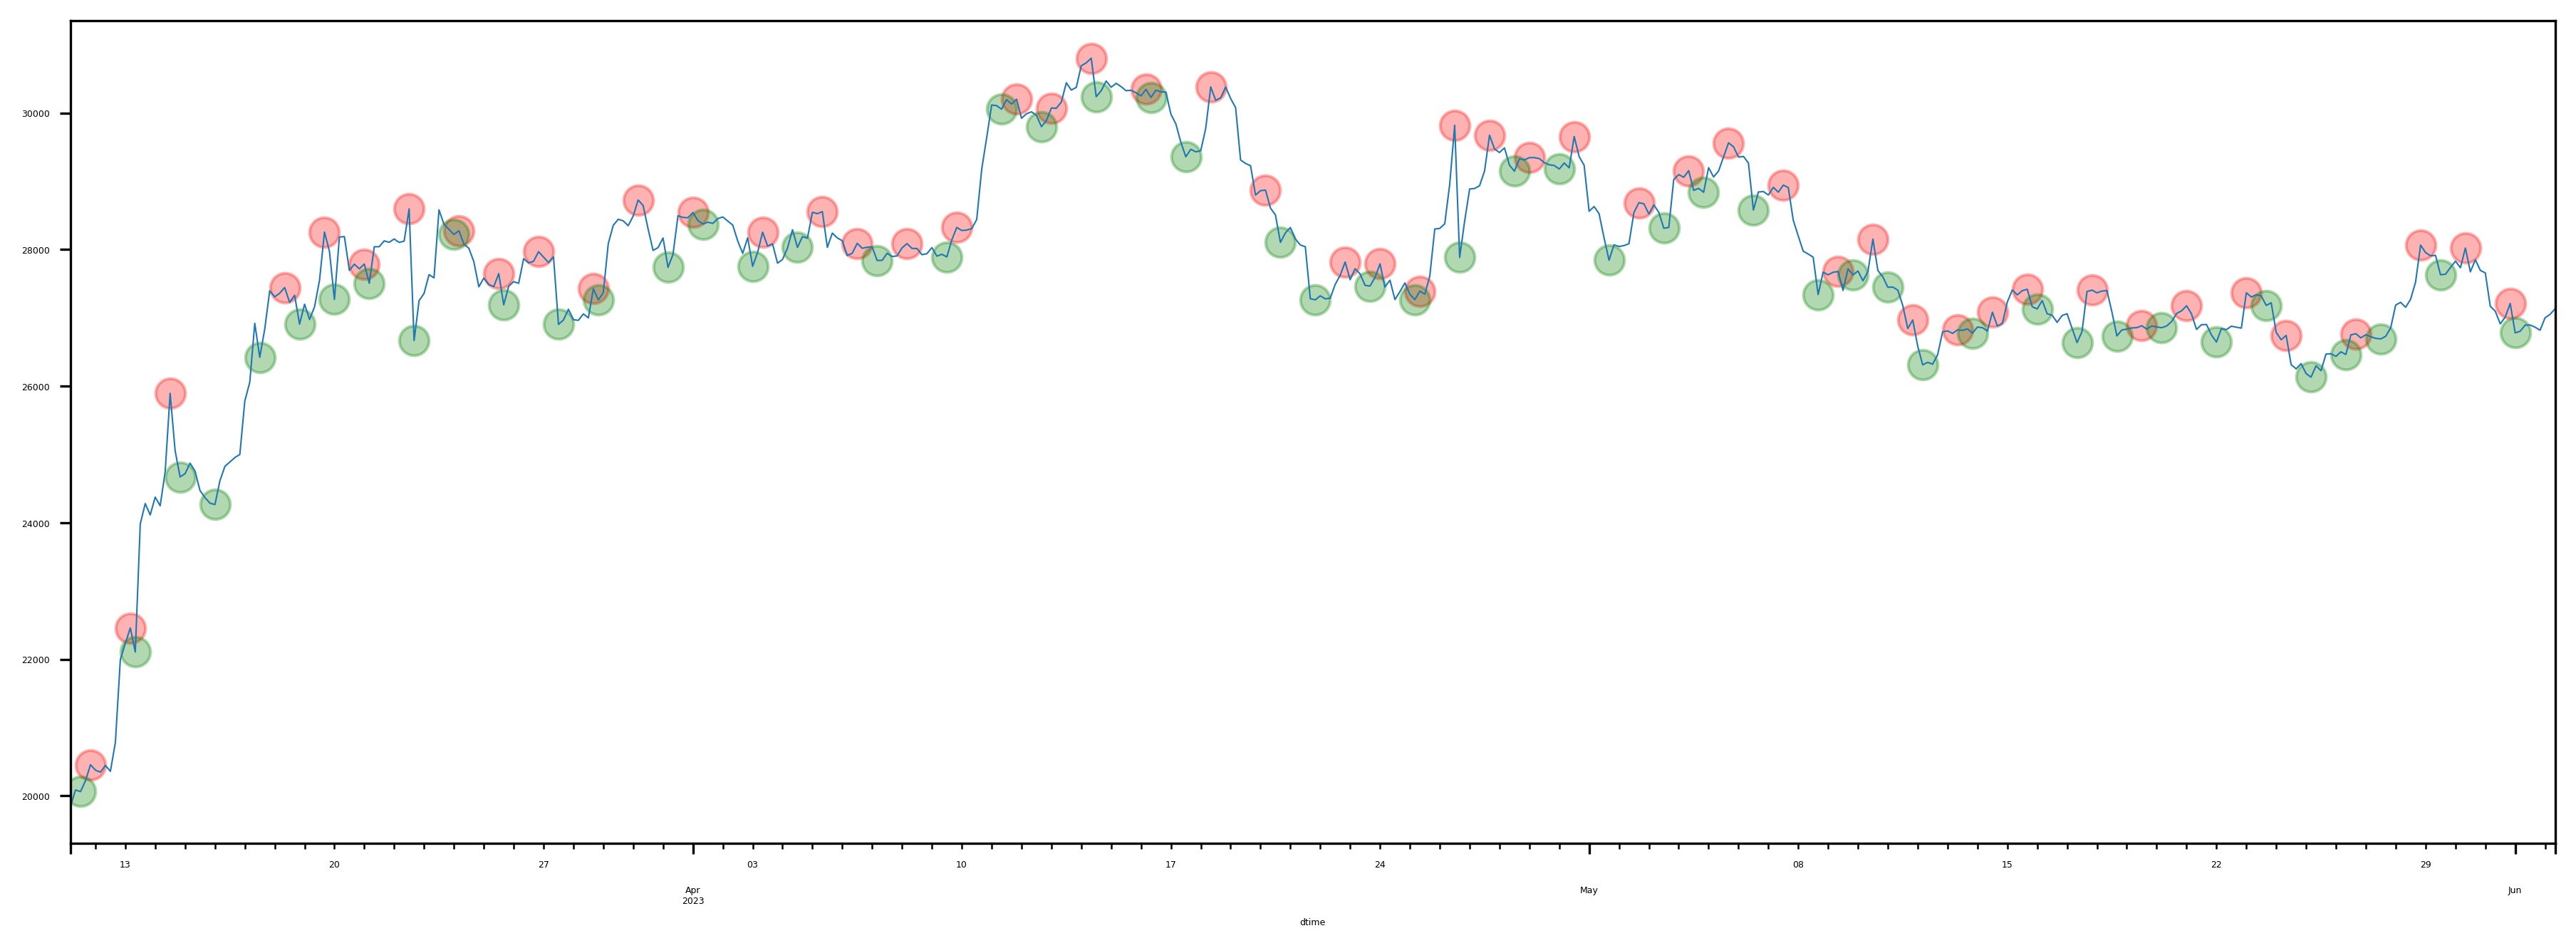

In [147]:

wdf = odf.iloc[-500:].copy()

peak_dist = 7

i_upeaks, _ = find_peaks(wdf.close, distance=peak_dist)
ix_upeaks = wdf.index[i_upeaks]
i_dpeaks, _ = find_peaks(-wdf.close, distance=peak_dist)
ix_dpeaks = wdf.index[i_dpeaks]

plt.figure(figsize=(15,5))
ax1 = wdf.close.plot()
ax1.scatter(ix_upeaks, wdf.loc[ix_upeaks].close, c='r', alpha=0.3, s=100)
ax1.scatter(ix_dpeaks, wdf.loc[ix_dpeaks].close, c='g', alpha=0.3, s=100)

In [161]:
# import logging

# logging.basicConfig(filename="minizinc-python.log", level=logging.DEBUG)
wdf = None
def printer(ws):
    global wdf
    wstart = ws * wlen
    wend = wstart + wlen
    wdf = odf.iloc[wstart:wend].copy()

    peak_dist = 12

    i_upeaks, _ = find_peaks(wdf.close, distance=peak_dist)
    ix_upeaks = wdf.index[i_upeaks]
    i_dpeaks, _ = find_peaks(-wdf.close, distance=peak_dist)
    ix_dpeaks = wdf.index[i_dpeaks]

    m = 5
    ### upeaks
    # mzn_result = call_mzn_model("rolling-last-n", {'idxs': i_upeaks.tolist(), 'm': m, 'n': wdf.shape[0]})
    wdf['i_upeaks'] = call_mzn_model("rolling-last-n", {'idxs': i_upeaks.tolist(), 'm': m, 'n': wdf.shape[0]})['result']
    wdf['upeaks'] = [wdf.iloc[i,:]['close'].values for i in wdf.i_upeaks.values]
    ### dpeaks
    # mzn_result = call_mzn_model("rolling-last-n", {'idxs': i_dpeaks.tolist(), 'm': m, 'n': wdf.shape[0]})
    wdf['i_dpeaks'] = call_mzn_model("rolling-last-n", {'idxs': i_dpeaks.tolist(), 'm': m, 'n': wdf.shape[0]})['result']
    wdf['dpeaks'] = [wdf.iloc[i,:]['close'].values for i in wdf.i_dpeaks.values]
    ###

    vupeaks = np.transpose(wdf.upeaks.values.tolist())
    vdpeaks = np.transpose(wdf.dpeaks.values.tolist())
    # up, down = wdf[wdf.close >= wdf.open], wdf[wdf.close < wdf.open]

    plt.figure(figsize=(15,5))
    ax1 = wdf.close.plot(lw=0.005)
    # ax1 = plt.subplots(1,1)
    plot_candles(wdf,ax=ax1)
    # ax1.bar(down.index, down.high-down.open, 2, bottom=down.open, color='red')
    ax1.scatter(ix_upeaks, wdf.loc[ix_upeaks].close, c='r', alpha=0.3, s=100)
    ax1.scatter(ix_dpeaks, wdf.loc[ix_dpeaks].close, c='g', alpha=0.3, s=100)
    for i in range(m):
        # ax1.scatter(wdf.index, vupeaks[i], s=0.1)
        ax1.scatter(wdf.index, vdpeaks[i], s=0.05)
    # ax1.scatter(ix_dpeaks, wdf.loc[ix_dpeaks].close, c='g', alpha=0.3, s=100)
wlen = 200
interact(printer, ws=(0,odf.shape[0] // wlen, 1))

interactive(children=(IntSlider(value=31, description='ws', max=63), Output()), _dom_classes=('widget-interact…

<function __main__.printer(ws)>

In [167]:
### returns since peaks
# vupeaks = np.transpose(wdf.upeaks.values.tolist())
m=5
vdpeaks = np.transpose(wdf.dpeaks.values.tolist())
pd.concat({
    f'dpk_lret_{j}': peak_lrets
    for j in range(m)
    for peak_lrets in [wdf.close.divide(peaks).apply(np.log) for i in range(m) for peaks in [vdpeaks[i]]]
}, axis=1)
# vdpeaks

,dpk_lret_0,dpk_lret_1,dpk_lret_2,dpk_lret_3,dpk_lret_4
dtime,,,,,
2020-06-18 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-06-18 08:00:00,-0.000813,-0.000813,-0.000813,-0.000813,-0.000813
2020-06-18 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-06-18 16:00:00,0.001278,0.001278,0.001278,0.001278,0.001278
2020-06-18 20:00:00,0.000035,0.000035,0.000035,0.000035,0.000035
...,...,...,...,...,...
2020-07-20 16:00:00,0.004241,0.004241,0.004241,0.004241,0.004241
2020-07-20 20:00:00,0.004474,0.004474,0.004474,0.004474,0.004474
2020-07-21 00:00:00,0.006660,0.006660,0.006660,0.006660,0.006660


In [168]:
wdf

,timestamp,open,high,low,close,volume,i_upeaks,upeaks,i_dpeaks,dpeaks
dtime,,,,,,,,,,
2020-06-18 04:00:00,1592452800000,9431.48,9455.00,9407.12,9440.34,4211.343143,"[0, 0, 0, 0, 0]","[9440.34, 9440.34, 9440.34, 9440.34, 9440.34]","[0, 0, 0, 0, 0]","[9440.34, 9440.34, 9440.34, 9440.34, 9440.34]"
2020-06-18 08:00:00,1592467200000,9440.82,9489.00,9380.00,9432.67,6599.564475,"[0, 0, 0, 0, 0]","[9440.34, 9440.34, 9440.34, 9440.34, 9440.34]","[0, 0, 0, 0, 0]","[9440.34, 9440.34, 9440.34, 9440.34, 9440.34]"
2020-06-18 12:00:00,1592481600000,9432.67,9445.00,9381.00,9385.99,7578.085949,"[0, 0, 0, 0, 0]","[9440.34, 9440.34, 9440.34, 9440.34, 9440.34]","[0, 0, 0, 0, 2]","[9440.34, 9440.34, 9440.34, 9440.34, 9385.99]"
2020-06-18 16:00:00,1592496000000,9385.99,9419.64,9335.50,9397.99,7027.659689,"[0, 0, 0, 0, 3]","[9440.34, 9440.34, 9440.34, 9440.34, 9397.99]","[0, 0, 0, 0, 2]","[9440.34, 9440.34, 9440.34, 9440.34, 9385.99]"
2020-06-18 20:00:00,1592510400000,9397.99,9416.65,9280.00,9386.32,7864.555945,"[0, 0, 0, 0, 3]","[9440.34, 9440.34, 9440.34, 9440.34, 9397.99]","[0, 0, 0, 0, 2]","[9440.34, 9440.34, 9440.34, 9440.34, 9385.99]"
...,...,...,...,...,...,...,...,...,...,...
2020-07-20 16:00:00,1595260800000,9173.82,9203.60,9146.43,9158.65,8088.931381,"[124, 136, 151, 167, 190]","[9436.06, 9288.34, 9309.04, 9203.59, 9208.99]","[117, 132, 156, 169, 188]","[9238.5, 9154.99, 9181.01, 9081.61, 9119.89]"
2020-07-20 20:00:00,1595275200000,9158.64,9185.00,9141.19,9160.78,4546.205589,"[124, 136, 151, 167, 190]","[9436.06, 9288.34, 9309.04, 9203.59, 9208.99]","[117, 132, 156, 169, 188]","[9238.5, 9154.99, 9181.01, 9081.61, 9119.89]"
2020-07-21 00:00:00,1595289600000,9160.78,9195.41,9152.80,9180.83,4410.680009,"[124, 136, 151, 167, 190]","[9436.06, 9288.34, 9309.04, 9203.59, 9208.99]","[117, 132, 156, 169, 188]","[9238.5, 9154.99, 9181.01, 9081.61, 9119.89]"


In [7]:
wdf = odf.copy()

peak_dists = [5,10,15,20,30]

jdf_spans = pd.concat(
{
    f'peak_dist_{peak_dist}' : 
    wdf[[]].join(df)#.swaplevel(axis=1)#.unstack()
    # pd.DataFrame(spans).set_axis(['dtime', 'i_', 'i_peak', 'n_', 'i_start', 'i_end'], axis=1).set_index('dtime')
    for peak_dist in peak_dists
    for (i_upeaks, _) in [find_peaks(wdf.close, distance=peak_dist)]
    for spans in [[
        [wdf.index[i_], i_, i_peak, i_ - i_peak, i_start, i_end]
        # pd.DataFrame([wdf.index[i_], i_, i_peak, i_ - i_peak, i_start, i_end]).set_axis(['dtime', 'i_', 'i_peak', 'n_', 'i_start', 'i_end'], axis=1).set_index('dtime')
        for i_peak in i_upeaks
        for i_start in [i_peak + peak_dist]
        for i_end in [min(wdf.shape[0] - 1, i_start + int(peak_dist/3*2))]
        for i_ in range(i_start,i_end+1)
        # for spans in [[wdf.index[i_], i_, i_peak, i_ - i_peak, i_start, i_end]]
    ]]
    for df in [pd.DataFrame(spans).set_axis(['dtime', 'i_', 'i_peak', 'n_', 'i_start', 'i_end'], axis=1).set_index('dtime')]
    # , i_end in range(ipk + peak_dist, min(wdf.shape[0] - 1, ipk + peak_dist + int(peak_dist/2))))  
}, axis=1)#.swaplevel()#.unstack()
# print(df_spans.shape,wdf.shape)
jdf_spans

peak_dist_5                              peak_dist_10  \
                             i_  i_peak   n_ i_start   i_end           i_   
dtime                                                                       
2019-07-05 12:00:00         NaN     NaN  NaN     NaN     NaN          NaN   
2019-07-05 16:00:00         NaN     NaN  NaN     NaN     NaN          NaN   
2019-07-05 20:00:00         NaN     NaN  NaN     NaN     NaN          NaN   
2019-07-06 00:00:00         NaN     NaN  NaN     NaN     NaN          NaN   
2019-07-06 04:00:00         NaN     NaN  NaN     NaN     NaN          NaN   
...                         ...     ...  ...     ...     ...          ...   
2023-07-16 04:00:00      8828.0  8823.0  5.0  8828.0  8831.0          NaN   
2023-07-16 08:00:00      8829.0  8823.0  6.0  8828.0  8831.0          NaN   
2023-07-16 12:00:00      8830.0  8823.0  7.0  8828.0  8831.0          NaN   
2023-07-16 16:00:00      8831.0  8823.0  8.0  8828.0  8831.0          NaN   
2023-07-16 20:00:00         NaN     NaN  NaN     NaN     NaN          NaN   

                                              ... peak_dist_20             \
                    i_peak  n_ i_start i_end  ...           i_ i_peak  n_   
dtime                                         ...                           
2019-07-05 12:00:00    NaN NaN     NaN   NaN  ...          NaN    NaN NaN   
2019-07-05 16:00:00    NaN NaN     NaN   NaN  ...          NaN    NaN NaN   
2019-07-05 20:00:00    NaN NaN     NaN   NaN  ...          NaN    NaN NaN   
2019-07-06 00:00:00    NaN NaN     NaN   NaN  ...          NaN    NaN NaN   
2019-07-06 04:00:00    NaN NaN     NaN   NaN  ...          NaN    NaN NaN   
...                    ...  ..     ...   ...  ...          ...    ...  ..   
2023-07-16 04:00:00    NaN NaN     NaN   NaN  ...          NaN    NaN NaN   
2023-07-16 08:00:00    NaN NaN     NaN   NaN  ...          NaN    NaN NaN   
2023-07-16 12:00:00    NaN NaN     NaN   NaN  ...          NaN    NaN NaN   
2023-07-16 16:00:00    NaN NaN     NaN   NaN  ...          NaN    NaN NaN   
2023-07-16 20:00:00    NaN NaN     NaN   NaN  ...          NaN    NaN NaN   

                                  peak_dist_30                           
                    i_start i_end           i_ i_peak  n_ i_start i_end  
dtime                                                                    
2019-07-05 12:00:00     NaN   NaN          NaN    NaN NaN     NaN   NaN  
2019-07-05 16:00:00     NaN   NaN          NaN    NaN NaN     NaN   NaN  
2019-07-05 20:00:00     NaN   NaN          NaN    NaN NaN     NaN   NaN  
2019-07-06 00:00:00     NaN   NaN          NaN    NaN NaN     NaN   NaN  
2019-07-06 04:00:00     NaN   NaN          NaN    NaN NaN     NaN   NaN  
...                     ...   ...          ...    ...  ..     ...   ...  
2023-07-16 04:00:00     NaN   NaN          NaN    NaN NaN     NaN   NaN  
2023-07-16 08:00:00     NaN   NaN          NaN    NaN NaN     NaN   NaN  
2023-07-16 12:00:00     NaN   NaN          NaN    NaN NaN     NaN   NaN  
2023-07-16 16:00:00     NaN   NaN          NaN    NaN NaN     NaN   NaN  
2023-07-16 20:00:00     NaN   NaN          NaN    NaN NaN     NaN   NaN  

[8833 rows x 25 columns]

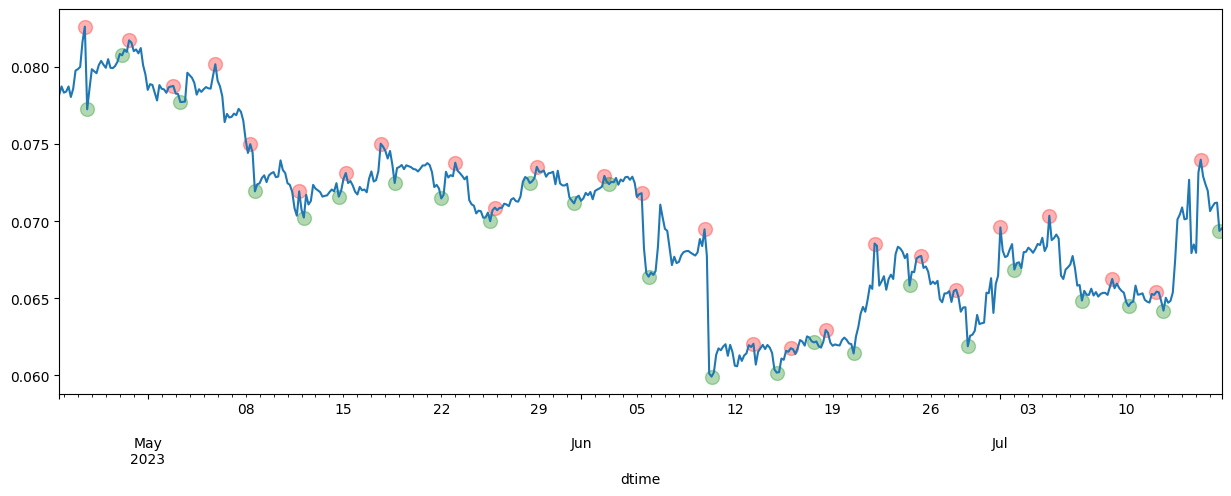

In [6]:
peak_dist = 15

wdf = odf.iloc[-500:]

# wdf_spans = df_spans.loc[wdf.index][f'peak_dist_5']

i_upeaks, _ = find_peaks(wdf.close, distance=peak_dist)
ix_upeaks = wdf.index[i_upeaks]
i_dpeaks, _ = find_peaks(-wdf.close, distance=peak_dist)
ix_dpeaks = wdf.index[i_dpeaks]

plt.figure(figsize=(15,5))
ax1 = wdf.close.plot()
ax1.scatter(ix_upeaks, wdf.loc[ix_upeaks].close, c='r', alpha=0.3, s=100)
ax1.scatter(ix_dpeaks, wdf.loc[ix_dpeaks].close, c='g', alpha=0.3, s=100)

In [862]:
fus = [1,2,3,4,5,6]
furet_cols = [f'furet_{fu}' for fu in fus]

lags = [2,3,4,6]

# def add_peaks(wdf):


# wdf = odf[:].copy()
def add_indicators(wdf):
    wdf['bod'] = wdf[['open', 'close']].min(axis=1)
    wdf['bou'] = wdf[['open', 'close']].max(axis=1)
    
    wdf['i_now'] = range(wdf.shape[0])
    wdf['lret'] = wdf.close.divide(wdf.close.shift()).apply(np.log)

    #####################################################
    ### Peaks

    i_upeaks, _ = find_peaks(wdf.close, distance=peak_dist)
    ix_upeaks = wdf.index[i_upeaks]
    i_dpeaks, _ = find_peaks(-wdf.close, distance=peak_dist)
    ix_dpeaks = wdf.index[i_dpeaks]

    a_last_peaks = np.array([
        [idf, ipk, *wdf.index[[idf, ipk]]]
        for ipk in i_upeaks

        for idf in list(range(ipk + 1, min(wdf.shape[0] - 1, ipk + 1 + int(peak_dist/2))))
    ]).T

    wdf.loc[a_last_peaks[2],'iupk'] = a_last_peaks[1]
    wdf.loc[a_last_peaks[2],'ixupk'] = a_last_peaks[3]
    wdf.loc[a_last_peaks[2],'n_upk'] = wdf.loc[a_last_peaks[2],'inow'] - a_last_peaks[1]

    wdf.loc[a_last_peaks[2], 'upk_close'] = wdf.loc[a_last_peaks[3]].close.values
    wdf.loc[a_last_peaks[2], 'upk_ret'] = wdf.loc[a_last_peaks[2], 'close'] / wdf.loc[a_last_peaks[2], 'upk_close']  - 1

    #####################################################
    ### Future returns

    wdf = wdf.join(pd.concat([ wdf.close.shift(-fu) / wdf.close - 1 for fu in fus ], axis=1).set_axis(furet_cols, axis=1)
                )

    #####################################################
    ### Recent Standaard Deviations
    
    la_cols = [f'bod_std_{la}' for la in lags]

    wdf = wdf.join(pd.concat([
        wdf.bod.rolling(la).std()
        for la in lags
        ],axis=1).set_axis(la_cols, axis=1))
    wdf.sort_index(inplace=True)
    # wdf.fillna(0)
    return wdf

In [742]:
wdf.columns


Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'bod', 'bou',
       'inow', 'lret', 'iupk', 'ixupk', 'n_upk', 'upk_close', 'upk_ret',
       'furet_1', 'furet_2', 'furet_3', 'furet_4', 'furet_5', 'furet_6',
       'bod_std_2', 'bod_std_3', 'bod_std_4', 'bod_std_6'],
      dtype='object')

In [846]:
tdf = wdf.dropna().copy()

features = ['upk_ret', 'n_upk', 'bod_std_6', 'bod_std_3', 'bod_std_2' ]
X = tdf[features]

y = np.where(tdf['furet_3'] < 0 , -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=False, train_size=0.25)

# Instantiate KNN learning model(k=15)
knn = KNeighborsClassifier(n_neighbors=30)

# fit the model
knn.fit(X_train, y_train)

# Accuracy Score
accuracy_train = accuracy_score(y_train, knn.predict(X_train))
accuracy_test = accuracy_score(y_test, knn.predict(X_test))

print ('Train_data Accuracy: %.2f' %accuracy_train)
print ('Test_data Accuracy: %.2f' %accuracy_test)

Train_data Accuracy: 0.59
Test_data Accuracy: 0.55


In [847]:
# zdf = tdf.inow - tdf.inow.shift()
# zdf[zdf < 0]
X_train.tail(5), X_test.head(5)

(                      upk_ret n_upk  bod_std_6  bod_std_3  bod_std_2
 dtime                                                               
 2020-07-02 16:00:00 -0.010028     2   0.000010   0.000012   0.000003
 2020-07-03 08:00:00 -0.009846     1   0.000004   0.000003   0.000003
 2020-07-03 12:00:00 -0.006664     2   0.000003   0.000003   0.000005
 2020-07-04 20:00:00 -0.008146     1   0.000006   0.000008   0.000010
 2020-07-05 00:00:00 -0.004827     2   0.000006   0.000008   0.000001,
                       upk_ret n_upk  bod_std_6  bod_std_3  bod_std_2
 dtime                                                               
 2020-07-06 00:00:00 -0.003604     1   0.000007   0.000004   0.000001
 2020-07-06 04:00:00  0.009032     2   0.000005   0.000004   0.000004
 2020-07-07 08:00:00 -0.034609     1   0.000167   0.000082   0.000059
 2020-07-07 12:00:00 -0.008509     2   0.000141   0.000047   0.000003
 2020-07-09 00:00:00 -0.088004     1   0.000330   0.000392   0.000224)

In [848]:
X.shape, tdf.shape, wdf.shape

((2392, 5), (2392, 25), (8833, 25))

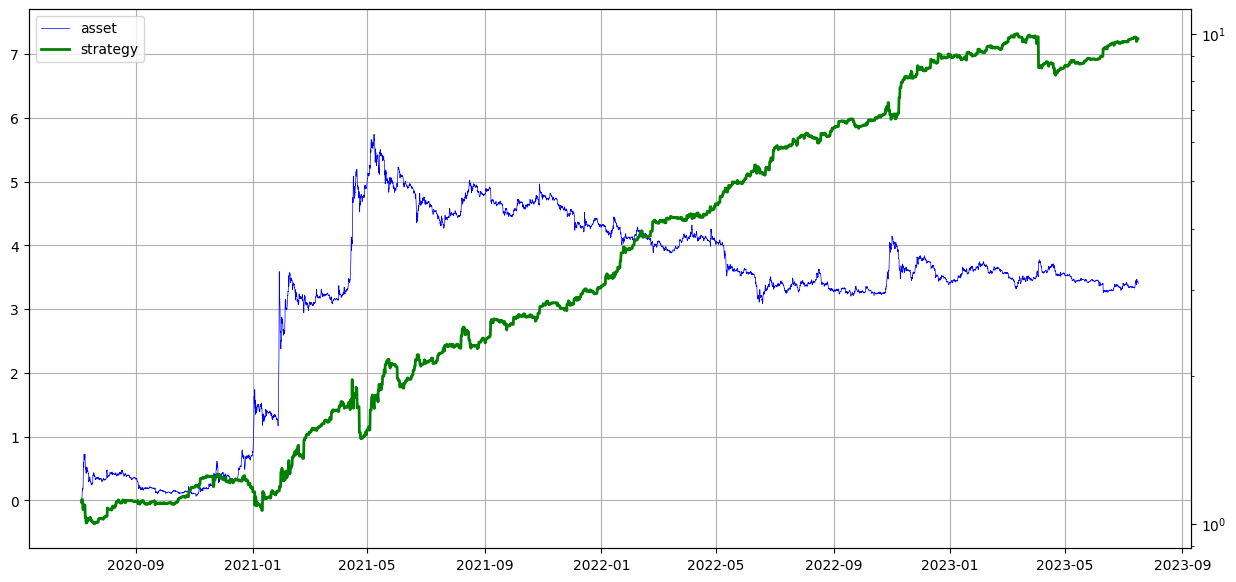

In [859]:
# Predicted Signal
# tdf = wdf.
y_hat = knn.predict(X)
# y_hat = y_hat[y_hat < 0]
tdf['y_hat'] = y_hat

start =  X_test.index.values[000]

# start =  X_test.index[0]
twdf = wdf.join(tdf[['y_hat']])[start:]
# Cumulative Strategy Returns 
twdf['strategy'] = (twdf['furet_2'] - 0.002) * (twdf['y_hat'] ).fillna(0)#.shift(1)


Cumulative_Strategy_returns = twdf['strategy'].cumsum() 

# SPY Cumulative Returns
Cumulative_Asset_returns = twdf['lret'].cumsum()
# Plot the results to visualize the performance

fig = plt.figure(figsize=(15,7))
ax1 = fig.subplots(1,1)
for ax in [ax1]: ax.grid()

# plt.axvline(X_test.index[0])
ax1.plot(Cumulative_Asset_returns, color='b', lw=0.5,label = 'asset')
ax1.plot(Cumulative_Strategy_returns, color='g', lw=2, label = 'strategy')
ax1tw = ax1.twinx()
# tw
ax1.legend()

ax1tw.set_yscale('log')

plt.show()

In [855]:
twdf.close

dtime
2020-07-06 00:00:00    0.002295
2020-07-06 04:00:00    0.002324
2020-07-06 08:00:00    0.002360
2020-07-06 12:00:00    0.002417
2020-07-06 16:00:00    0.002478
                         ...   
2023-07-16 04:00:00    0.070940
2023-07-16 08:00:00    0.071170
2023-07-16 12:00:00    0.071200
2023-07-16 16:00:00    0.069370
2023-07-16 20:00:00    0.069520
Name: close, Length: 6636, dtype: float64

In [841]:
X_train.tail(5), X_test.head(5)

(                      upk_ret n_upk  bod_std_6     bod_std_3     bod_std_2
 dtime                                                                     
 2021-03-28 00:00:00 -0.003695     2   0.000350  4.854290e-05  9.899495e-06
 2022-05-28 20:00:00  0.000000     2   0.000354  3.214550e-04  7.071068e-05
 2020-10-14 04:00:00 -0.001213     2   0.000008  6.244998e-07  2.121320e-07
 2020-11-25 04:00:00 -0.055128     2   0.000105  7.782682e-05  0.000000e+00
 2022-04-12 16:00:00 -0.047887     2   0.002464  2.421432e-03  3.181981e-03,
                       upk_ret n_upk  bod_std_6  bod_std_3  bod_std_2
 dtime                                                               
 2019-12-31 04:00:00 -0.003158     2   0.000006   0.000004   0.000003
 2021-08-24 12:00:00 -0.072265     2   0.008489   0.011288   0.013916
 2020-01-22 00:00:00 -0.006041     1   0.000022   0.000012   0.000015
 2020-11-15 16:00:00 -0.015227     1   0.000012   0.000016   0.000018
 2019-12-08 16:00:00 -0.006688     1   0.000014

In [860]:

# Its important to use binary mode 
with open(f'models/bottomOut-{pair}-{timeframe}--{(Cumulative_Strategy_returns.loc[twdf.index[-5]] * 100).round().astype(int)}--knnpickle', 'wb') as knnPickle:
    pickle.dump(knn, knnPickle)  

# close the file
# knnPickle.close()
                
      
# load the model from disk
# loaded_model = pickle.load(open('knnpickle_file', 'rb'))
# result = loaded_model.predict(X_test) 

In [861]:
# Calculate Sharpe ratio
Std = Cumulative_Strategy_returns.std()
Sharpe = (Cumulative_Strategy_returns-0)/Std
Sharpe = Sharpe.mean()
print('Sharpe ratio: %.2f'%Sharpe )

Sharpe ratio: 1.44
